## Time series cross-validation

A more sophisticated version of training/test sets is time series cross-validation. In this procedure, there are a series of test sets, each consisting of a single observation. The corresponding training set consists only of observations that occurred prior to the observation that forms the test set. Thus, no future observations can be used in constructing the forecast. Since it is not possible to obtain a reliable forecast based on a small training set, the earliest observations are not considered as test sets.

The following diagram illustrates the series of training and test sets, where the blue observations form the training sets, and the orange observations form the test sets.

![](Assets/cross-validation.png)

The forecast accuracy is computed by averaging over the test sets. This procedure is sometimes known as “evaluation on a rolling forecasting origin” because the “origin” at which the forecast is based rolls forward in time.

With time series forecasting, one-step forecasts may not be as relevant as multi-step forecasts. In this case, the cross-validation procedure based on a rolling forecasting origin can be modified to allow multi-step errors to be used. Suppose that we are interested in models that produce good 4-step-ahead forecasts. Then the corresponding diagram is shown below.

![](Assets/cross-validation-2.png)


In the following example, we compare the accuracy obtained via time series cross-validation with the residual accuracy. In this example, we start with a training set of length .init=3, and increasing the size of successive training sets by .step=1.

In [3]:
# Import the libraries that we are going to use for the analysis:
import random
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import Naive

In [6]:
# Auxiliar plot functions
def plot_cv_indices(cv_indices, total_obs, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    colors = {0: "tab:blue", 1: "tab:orange", 2: "tab:gray"}
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_indices):
        # Fill in indices with the training/test groups
        indices = np.array([2] * total_obs)
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=pd.Series(indices).map(colors),
            marker="_",
            lw=lw,
            # cmap=cmap_cv,
            # vmin=-0.2,
            # vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Index",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
        xlim=[0, total_obs],
    )
    ax.set_title("Cross-validation splits", fontsize=15)
    return ax


def plot_grid(df_train, plot_titles, df_test=None, plot_random=True):
    """Plots multiple time series."""
    fig, axes = plt.subplots(4, 2, figsize=(24, 14))

    unique_ids = df_train["unique_id"].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"

    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query("unique_id == @uid")
        axes[idx, idy].plot(train_uid["ds"], train_uid["y"], label="y_train", c="black")
        axes[idx, idy].xaxis.set_tick_params(rotation=45)
        if df_test is not None:
            max_ds = train_uid["ds"].max()
            test_uid = df_test.query("unique_id == @uid")
            axes[idx, idy].plot(test_uid["ds"], test_uid["y"], c="black", label="True")
            axes[idx, idy].plot(test_uid["ds"], test_uid["y_5"], c="blue", alpha=0.3)
            axes[idx, idy].plot(test_uid["ds"], test_uid["y_50"], c="blue", label="p50")
            axes[idx, idy].plot(test_uid["ds"], test_uid["y_95"], c="blue", alpha=0.3)
            axes[idx, idy].fill_between(
                x=test_uid["ds"],
                y1=test_uid["y_5"],
                y2=test_uid["y_95"],
                alpha=0.2,
                label="p5-p95",
            )
        axes[idx, idy].set_title(f"State: {plot_titles[uid]}")
        axes[idx, idy].set_xlabel("Timestamp [t]")
        axes[idx, idy].set_ylabel("Target")
        axes[idx, idy].legend(loc="upper left")
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.7)
    plt.show()

*In this procedure there is a series of test sets. The corresponding training sets consist only of observations that ocurred prior to the observations from the test set. Thus, no future observations can be used in constructing the forecast. The following diagram illustrates the series of training and test sets, where the blue observations form the training sets, and the orange observations form the test sets. The forecast accuracy is computed by averaging over the test sets.*

<Axes: title={'center': 'Cross-validation splits'}, xlabel='Index', ylabel='CV iteration'>

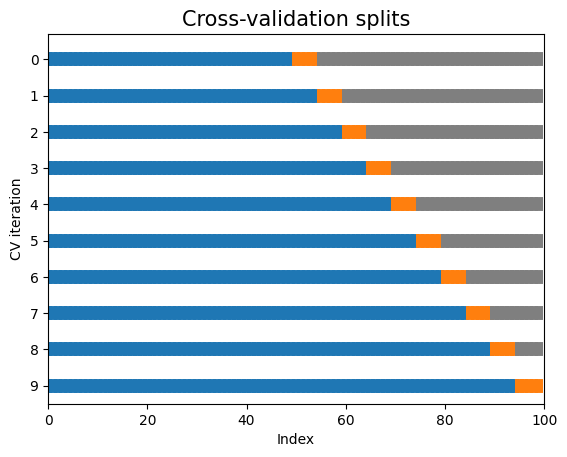

In [7]:
total_obs = 100
nfolds = 10
cv_indices = []

for i in range(1, nfolds + 1)[::-1]:
    cutoff = 100 - i * 5
    cv_indices.append((np.array(range(cutoff)), np.array(range(cutoff, cutoff + 5))))

fig, ax = plt.subplots()
plot_cv_indices(cv_indices, total_obs, ax, nfolds)

### Loading and Exploring Google stock Data:

In [8]:
# Create a dataframe from a csv file:
google_stock = pd.read_csv("Assets/GOOGL.csv")

# Filter the year of interest:
google_mask = google_stock["Date"] <= "2015-12-31"
google_2015 = google_stock.loc[google_mask]

# Filter the year of interest:
google_mask = google_stock["Date"] > "2015-12-31"
google_2016 = google_stock.loc[google_mask]

# Define a new dataframe with daily close prices and dates:
google_train = google_2015[["Date", "Close"]].copy()
google_test = google_2016[["Date", "Close"]].copy()

# Rename columns:
google_train.columns = ["ds", "y"]
google_test.columns = ["ds", "y"]

# Create a new column in the dataframe, unique_id:
google_train["unique_id"] = "Close price"
google_test["unique_id"] = "Close price"

# Convert string Date time into Python Date time object:
google_train["ds"] = pd.to_datetime(google_train["ds"])
google_test["ds"] = pd.to_datetime(google_test["ds"])

### Prepare dataset for StatsForecast modelling:

In [12]:
# Create a dict maping string values in Quarter to datetime
days = google_2015["Date"].sort_values().unique()
print(len(days))
ds = pd.date_range(start="2015-01-02", periods=len(days), freq="D")
ds_quarter = dict(zip(days, ds))

252


In [14]:
# Modelling parameters
season_length = 4
horizon = 1
freq = "D"
n_windows_cv = 10

In [15]:
# Create forecast object and perform cross validation:
fcst = StatsForecast(
    models=[AutoARIMA(season_length=season_length)],
    freq=freq,
    n_jobs=-1,
)
forecasts_cv = fcst.cross_validation(df=google_train, h=horizon, n_windows=n_windows_cv, level=(90,))
forecasts_cv.head()

,unique_id,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
0,Close price,2015-12-17,2015-12-16,38.491501,38.931386,37.999830,39.862942
1,Close price,2015-12-18,2015-12-17,37.842499,38.441433,37.510655,39.372211
2,Close price,2015-12-21,2015-12-18,38.040001,37.771403,36.840402,38.702403
3,Close price,2015-12-22,2015-12-21,38.356499,38.071391,37.141877,39.000905
4,Close price,2015-12-23,2015-12-22,38.425499,38.390243,37.462151,39.318335


<Axes: title={'center': 'Cross-validation splits'}, xlabel='Index', ylabel='CV iteration'>

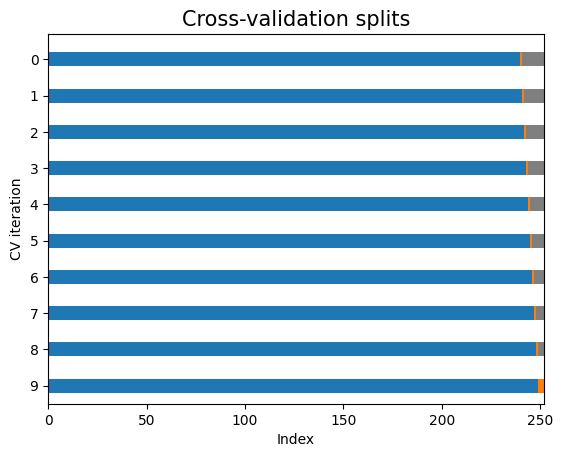

In [16]:
# Plot time series CV:
time_cv_indices = [
    (
        np.where(google_train.ds.values <= cutoff),
        np.where(google_train.ds.values == cutoff) + np.array(1),
    )
    for cutoff in forecasts_cv["cutoff"]
]

fig, ax = plt.subplots()
plot_cv_indices(time_cv_indices, google_train.shape[0], ax, n_windows_cv)

The accuracy() function can be used to evaluate the forecasts accuracy across the training sets.

In [17]:
def accuracy(df_forecast, y_train_serie, seasonallity):

    method = df_forecast.columns[2:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []

    y = df_forecast.obs_values.values
    y_hat_naive = df_forecast.naive_forecast.values
    scale = np.abs(y_train_serie[:-seasonallity] - y_train_serie[seasonallity:])
    scale = np.average(scale)

    for i in method:

        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs((y - y_hat) / y)) * 100
        mase = mae_f / scale
        mae_results.append(np.round(mae_f, 2))
        rmse_results.append(np.round(rmse_f, 2))
        mape_results.append(np.round(mape, 2))
        mase_results.append(np.round(mase, 2))

    accuracy_df = pd.DataFrame(
        {
            "Method": method,
            "RMSE": rmse_results,
            "MAE": mae_results,
            "MAPE": mape_results,
            "MASE": mase_results,
        }
    )

    return accuracy_df

In [18]:
# Since we are dealing with daily data, it would be benefitial to use 5 as seasonality.
models = [AutoARIMA(season_length=5, approximation=True), Naive()]

# Define the model, fit and predict:
fcst = StatsForecast(models=models, freq="D", n_jobs=-1)

# We can define the level of the forecast intervals we want to produce. StatsForecast will produce these levels:
levels = [90]

# The forecast function converts the forecast distributions into intervals:
forecasts = fcst.forecast(df=google_train.iloc[0:-7], h=10, level=levels)

/home/freddy/playground/fpp3-python/.venv/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/freddy/playground/fpp3-python/.venv/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/freddy/playground/fpp3-python/.venv/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/freddy/playground/fpp3-python/.venv/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/freddy/playground/fpp3-python/.venv/lib/python3.10/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/freddy/playground/fpp3-python/.venv/lib/python3.10/site-packages/statsforecast/arima.py:4

In [20]:
# Create a dataframe with the values predicted:
forecasts_df = pd.DataFrame(
    {
        "ds": forecasts_cv.ds,
        "obs_values": forecasts_cv["y"],
        "Cross-validation": forecasts_cv["AutoARIMA"],
        "Training": forecasts["AutoARIMA"],
        "naive_forecast": forecasts["Naive"],
    }
)

accuracy_df = accuracy(forecasts_df, google_train.y.values, 1)
accuracy_df

,Method,RMSE,MAE,MAPE,MASE
0,Cross-validation,0.45,0.39,1.01,1.07
1,Training,0.84,0.65,1.66,1.76
2,naive_forecast,0.86,0.67,1.70,1.81


As expected, the accuracy measures from the residuals are smaller, as the corresponding “forecasts” are based on a model fitted to the entire data set, rather than being true forecasts.

A good way to choose the best forecasting model is to find the model with the smallest RMSE computed using time series cross-validation.

## Example: Forecast horizon accuracy with cross-validation

The google_2015 subset of the gafa_stock data, plotted in Figure 5.9, includes daily closing stock price of Google Inc from the NASDAQ exchange for all trading days in 2015.

The code below evaluates the forecasting performance of 1- to 8-step-ahead drift forecasts. The plot shows that the forecast error increases as the forecast horizon increases, as we would expect.

In [37]:
"Forecast horizon accuracy with cross-validation example"

'Forecast horizon accuracy with cross-validation example'